# Ames Housing Price Prediction
**Name**: Saad Abbas
**Date**: 28-May-2019

### Contents
- [1.0 Introduction](#intro)
- [2.0 Exploratory Data Analysis](#eda)
- [3.0 Estimating the value of homes from fixed characteristics](#fixed)
- [4.0 Determine value of changeable characteristics unexplained by the fixed ones](#unfixed)
- [5.0 Future Question: What property characteristics predict an "abnormal" sale?](#abnormal)
_____________________

## 1.0 Introduction <a name="intro"></a>

Imagine that you have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). I will use this dataset to try answer some property-related business questions.

In [2]:
# Load the data
raw_housing = pd.read_csv('./datasets/housing.csv', index_col='Id')
raw_housing.index.name = None

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

%matplotlib inline

In [3]:
raw_housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2.0 Exploratory Data Analysis <a name="eda"></a>

In [4]:
# Filter dataframe to include only residential housing
housing = raw_housing[raw_housing['MSZoning'].str.contains('F|R')]

In [5]:
# Size of dataset
housing.shape

(1450, 80)

#### Columns with high count of same value

Columns which have a high count of the same value will not be beneficial to the prediction model. Below I will check what is percentage occurence of the highest occuring value for each column, then decide on how to deal with those features.

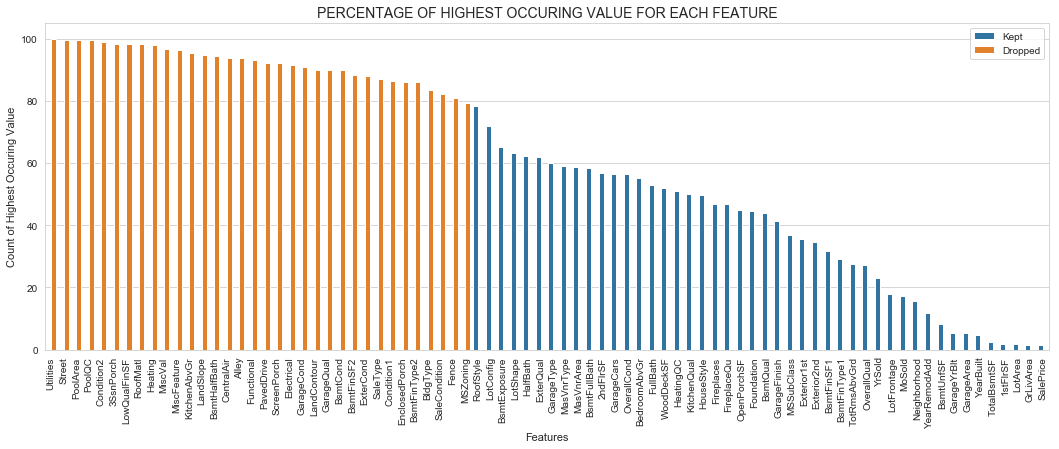

In [6]:
top_counts = list()

for col in housing.columns:
    top_counts.append(housing[col].value_counts(dropna=False).sort_values(ascending=False).iloc[0] / housing.shape[0]*100)

counts = pd.DataFrame({'feature': housing.columns, 'maxcount': top_counts}).sort_values('maxcount', ascending=False).reset_index(drop=True)
counts['low_variance'] = counts['maxcount'].apply(lambda x: 'Dropped' if x>79 else 'Kept')

fig, ax = plt.subplots(1,1, figsize=(18, 6))
sns.barplot(x='feature', y='maxcount', data=counts, ax=ax, hue='low_variance', hue_order=['Kept', 'Dropped'])
ax.set_xticklabels(labels=counts['feature'], rotation=90)
ax.set_xlabel('Features', fontsize=11)
ax.set_ylabel('Count of Highest Occuring Value', fontsize=11)
plt.title('PERCENTAGE OF HIGHEST OCCURING VALUE FOR EACH FEATURE', fontsize=14)
plt.legend(loc='upper right')
plt.show()

All of the the below columns have a value occuring more than 80% in the data:

1. **Utilities**: Almost all houses have all public utilities. This column can be dropped.
2. **Street**: Almost all houses have paved road access. This column can be dropped.
3. **PoolArea** / **PoolQC**: Almost all houses have no pool. These columns can be dropped.
4. **Condition1** / **Condition2**: 86% of the houses have 'normal' conditions. This column can be dropped.
5. **3SsnPorch**: I will add all porch areas to provide a single value for total porch area of the house.
6. **LowQualFinSF**: Almost all houses have no low quality finished area. This column can be dropped.
7. **RoofMatl**: Almost all houses have Composite Shingle roofs. This column can be dropped.
8. **Heating**: Almost all houses have gas-air heating. This column can be dropped.
9. **MiscFeature** / **MiscVal**: Almost all houses have no miscellaneous features. These columns can be dropped.
10. **KitchenAbvGr**: Almost all houses have 1 above ground kitchen. This column can be dropped.
11. **LandSlope**: Almost all houses have a gentle land slope. This column can be dropped.
12. **BsmtHalfBath**: This will be added with a 0.5 factor to BsmtFullBath then I can drop this column.
13. **CentralAir**: Almost all houses are centrally air-conditioned, so I can drop this column.
14. **Alley**: Almost all houses have no alley access. This column can be dropped.
15. **Functional**: Almost all houses have typical functionality, so I can drop this column.
16. **PavedDrive**: Almost all houses have a paved driveway, so I can drop this column.
17. **Electrical**: Almost all houses have a standard circuit breaker. This column can be dropped.
18. **GarageCond** / **GarageQual**: Almost all houses have an average Garage condition. These columns can be dropped.
19. **LandContour**: 90% of the houses have a flat land contour. This column can be dropped.
20. **BsmtCond**: Almost 90% of the houses have a typical Basement condition. This column can be dropped.
21. **BsmtFinSF2**: I already have the total basement area in a separate column, so I can drop this column.
22. **ExterCond**: Almost all houses have a typical external condition. This column can be dropped.
23. **BsmtFinType2**: 86% of the houses have an unfinished second basement, so this does not help our prediction. This column can be dropped.
24. **Fence**: 81% of houses have no fence, so this does not help my prediction. This column can be dropped.

#### Columns with missing (Null) values:

For all columns having missing values in our dataset, I we will investigate why there are missing values and decide on what action to take for that column to deal with the missing values.

In [7]:
# Percentage of Null values in the Dataframe (where there is a null value)
housing.isnull().sum()[housing.isnull().sum() > 0].sort_values(ascending=False) * 100 / housing.shape[0]

PoolQC          99.517241
MiscFeature     96.413793
Alley           93.862069
Fence           80.827586
FireplaceQu     46.965517
LotFrontage     17.862069
GarageYrBlt      5.448276
GarageType       5.448276
GarageFinish     5.448276
GarageQual       5.448276
GarageCond       5.448276
BsmtFinType2     2.620690
BsmtExposure     2.620690
BsmtFinType1     2.551724
BsmtCond         2.551724
BsmtQual         2.551724
MasVnrArea       0.551724
MasVnrType       0.551724
Electrical       0.068966
dtype: float64

1. **FirePlaceQu**: This corresponds to houses which have no fireplaces. This will be converted to numerical values later.
2. **LotFrontage**: We will consider these missing values to mean that there is no lot front to the house. We will convert Nan values to zero's.
3. **GarageType / GarageYrBlt / GarageFinish**: These values appear because there is no garage to the house. We will see later how to optimize these columns.
4. **BsmtExposure / BsmtFinType1 / BsmtQual**: These indicate that there is no basement in the house. We will see later how to optimize these columns.
5. **MasVnrArea / MasVnrType**: These indicate that there is no masonry veneer in the house. We will see later how to optimize these columns.

#### Check for column dtypes

I will look at the dtypes for all columns and identify if they are what we need them to be. If some columns are not as I require, I will list down which columns need conversion and of what type.

In [8]:
housing.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

#### >>> Int columns:

In [9]:
housing.select_dtypes(include=['int64']).columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

From the above, we can see the below possible changes:

1. *'MSSubClass'* is an identifier, and should be converted to object type.
2. *'MoSold'* & *'YrSold'* can be converted to a datetime, to check trend in sale prices.
3. *'YearBuilt'* & *'YearRemodAdd'* have duplicated values for half the observations (as seen below). We will keep only the *'YearRemodAdd'* column converted to the age of the house.
4. *'BsmtFinSF1'* & *'BsmtFinSF2'* will be dropped, as we have total Basement area in '*TotalBsmtSF*'.


Rows having no house modifications: 763


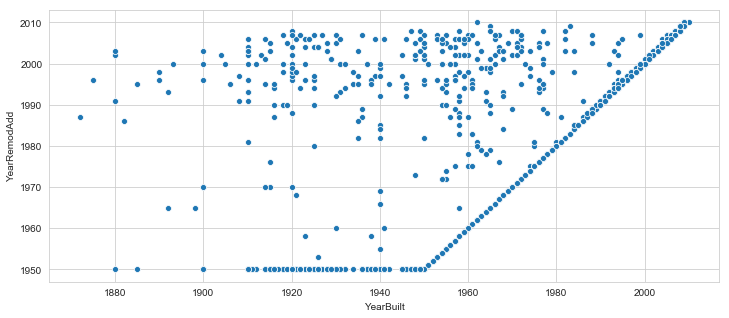

In [10]:
print('Rows having no house modifications:',housing[housing['YearBuilt']==housing['YearRemodAdd']].shape[0])

fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.scatterplot(x='YearBuilt', y='YearRemodAdd', data=housing, ax=ax)
plt.show()

#### >>> Float columns:

In [11]:
housing.select_dtypes(include=['float64']).columns

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

*'GarageYrBlt'* can be changed to Garage Age column.

#### >>> Object columns:

In [12]:
housing.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

The below columns related to Quality / Condition are describing the quality index of that feature of that house. We will convert these to numerical columns as they can be meaningfully ranked:
1. *'ExterQual'* : [Ex, Gd, TA, Fa, Po]
2. *'ExterCond'* : [Ex, Gd, TA, Fa, Po]
3. *'BsmtQual'* : [Ex, Gd, TA, Fa, Po, NA]
4. *'BsmtCond'* : [Ex, Gd, TA, Fa, Po, NA]
5. *'BsmtExposure* : [Gd, Av, Mn, No, NA]
6. *'BsmtFinType1'* : [GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA]
7. *'BsmtFinType2'* : [GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA]
8. *'HeatingQC'* : [Ex, Gd, TA, Fa, Po]
9. *'CentralAir'* : [Y, N]
10. *'KitchenQual'* : [Ex, Gd, TA, Fa, Po]
11. *'Functional'* : [Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal]
12. *'FireplaceQu'* : [Ex, Gd, TA, Fa, Po, NA]
13. *'GarageFinish'* : [Fn, RFn, Unf, NA]
14. *'GarageQual'* : [Ex, Gd, TA, Fa, Po, NA]
15. *'GarageCond'* : [Ex, Gd, TA, Fa, Po, NA]
16. *'PavedDrive'* : [Y, P, N]

## 3.0 Estimating the value of homes from fixed characteristics <a name="fixed"></a>

I will use machine learning tools to carry out the following:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Using the above information, a real estate company can buy houses that are likely to sell for more than the cost of the purchase plus renovations.

    
For item 1 above, I will build a regression model for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

I will create a separate DataFrame of the housing price data having only those features which cannot be changed. For the fixed feature dataframe, I will then implement the above identified modifications wherever applicable.

In [13]:
fixed_cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 
              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 
              'Foundation', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
              'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
              'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
              'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']

housing_fixed = housing[fixed_cols].copy()

In [14]:
# Change MSSubClass to str type
housing_fixed['MSSubClass'] = housing_fixed['MSSubClass'].apply(lambda x: str(x))

In [15]:
# Change LotFrontage Nan to 0
housing_fixed['LotFrontage'].fillna(0, inplace=True)

In [16]:
# Change YearRemodAdd to HouseAge & drop YearBuilt
housing_fixed['YearRemodAdd'] = housing_fixed['YrSold'] - housing_fixed['YearRemodAdd']
housing_fixed.drop(['YearBuilt'], axis=1, inplace=True)
housing_fixed.rename(columns={'YearRemodAdd': 'HouseAge'}, inplace=True)

for ind in housing_fixed.index:
    if housing_fixed.loc[ind, 'HouseAge'] < 0:
        housing_fixed.loc[ind, 'HouseAge'] = 0

In [17]:
# Converting GarageYrBlt to age based on year sold:
housing_fixed['GarageYrBlt'] = housing_fixed['YrSold'] - housing_fixed['GarageYrBlt']
housing_fixed.rename(columns={'GarageYrBlt': 'GarageAge'}, inplace=True)

In [18]:
# Change YrSold to Datetime
for i in housing_fixed.index:
    housing_fixed.loc[i, 'YrSold'] = datetime(housing_fixed.loc[i, 'YrSold'], housing_fixed.loc[i, 'MoSold'], 1)
housing_fixed['YrSold'] = pd.to_datetime(housing_fixed['YrSold'])
housing_fixed.drop(['MoSold'], axis=1, inplace=True)

In [19]:
# Add all porch areas together and rename to PorchSF
housing_fixed['OpenPorchSF'] = housing_fixed['OpenPorchSF'] + housing_fixed['EnclosedPorch'] + \
    housing_fixed['3SsnPorch'] + housing_fixed['ScreenPorch']
housing_fixed.rename(columns={'OpenPorchSF': 'PorchSF'}, inplace=True)
housing_fixed.drop(['EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1, inplace=True)

In [20]:
# Change ranked columns to numerical
conv_dict = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}
housing_fixed['BsmtExposure'] = housing_fixed['BsmtExposure'].apply(lambda x: conv_dict[x] if x in conv_dict else 0)

In [21]:
# Add BmstHalfBath to BsmtFullBath
housing_fixed['BsmtFullBath'] = housing_fixed['BsmtFullBath'] + (housing_fixed['BsmtHalfBath'] * 0.5)
housing_fixed.drop(['BsmtHalfBath'], axis=1, inplace=True)

In [22]:
# Add HalfBath to FullBath
housing_fixed['FullBath'] = housing_fixed['FullBath'] + (housing_fixed['HalfBath'] * 0.5)
housing_fixed.drop(['HalfBath'], axis=1, inplace=True)

In [23]:
# Add 'NA' for GarageType null values
housing_fixed['GarageType'].fillna('NA', inplace=True)

In [24]:
# Dropping columns with low variance:
housing_fixed.drop(['Street', 'Alley', 'LandContour', 'LandSlope', 'Condition1', 'Condition2', 'BsmtFinSF1',
                   'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'KitchenAbvGr', 'PoolArea'], axis=1, inplace=True)

### Checking for correlation between the features

Let us check for the correlations between the remaining features, and identify if any highly related columns are due to repeated data.

#### >>> Correlation between numerical columns:

In [25]:
pd.concat([housing_fixed, housing['SalePrice']], axis=1).corr()['SalePrice'].sort_values()

HouseAge       -0.503108
GarageAge      -0.486675
BedroomAbvGr    0.162008
PorchSF         0.207057
LotFrontage     0.214273
BsmtFullBath    0.221713
LotArea         0.264715
2ndFlrSF        0.319774
WoodDeckSF      0.320770
BsmtExposure    0.377944
TotRmsAbvGrd    0.533355
FullBath        0.593788
1stFlrSF        0.603300
TotalBsmtSF     0.612088
GarageArea      0.629831
GarageCars      0.642135
GrLivArea       0.708658
SalePrice       1.000000
Name: SalePrice, dtype: float64

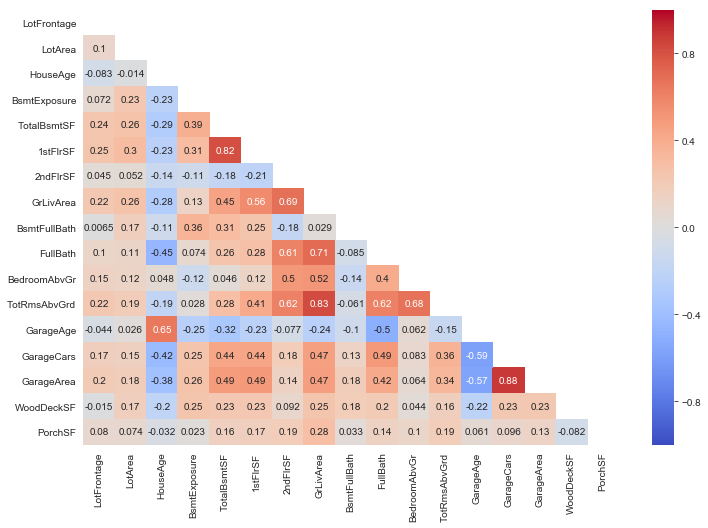

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

corr = housing_fixed.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, fmt='.2g', vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

Some columns with significant correlation are as the following:
1. **1stFlrSf** and **TotalBsmtSF**: This makes sense as larger basement will mean a larger 1st Floor. We will only consider TotalBsmtSF as it has a higher correlation with Sales.
2. **TotRmsAbvGrd** and **GrLivArea**: These seem to indicate a similar data about the house, as can be seen from the chart below. Since GrLivArea gives us a better correlation with the house price, we will ignore TotRmsAbvGr as a feature.
3. **2ndFlrSF** and **GrLivArea**: These seem to indicate a similar data about the house, as can be seen from the chart below. Since GrLivArea gives us a better correlation with the house price, we will ignore TotRmsAbvGr as a feature.
4. **TotRmsAbvGrd** and **BedroomAbvGr**: Total rooms already include bedrooms, so we have repeated information here. We can ignore the bedrooms above ground as a feature.
5. **GarageArea** and **GarageCars**: Again we have the same data presented in two different ways. Since GarageCars is giving us a SLIGHTLY higher correlation with house price, we can ignore GarageArea as a feature for our model.
6. There is no feature that has a significant negative correlation with another feature in the data.

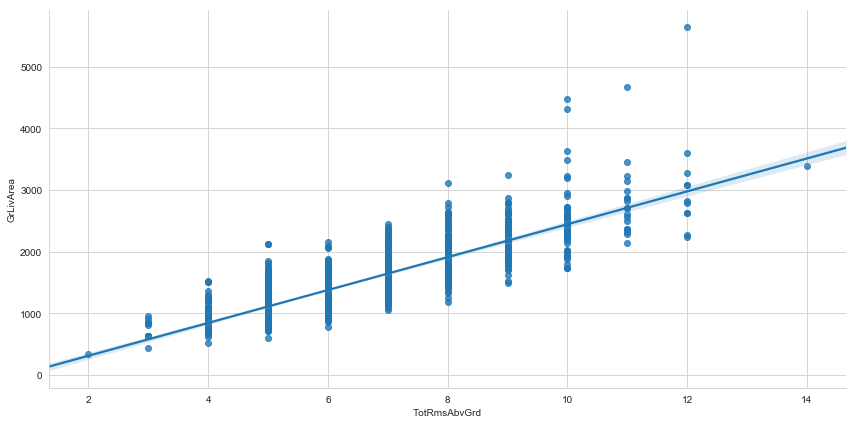

In [27]:
# Check correlation of TotTmsAbvGr with GrLivArea
sns.lmplot(x='TotRmsAbvGrd', y='GrLivArea', data=housing_fixed, height=6, aspect=2)
plt.show()

In [28]:
# Drop the highly correlated features
housing_fixed.drop(['1stFlrSF', 'TotRmsAbvGrd', '2ndFlrSF', 'BedroomAbvGr', 'GarageArea'], axis=1, inplace=True)

In [29]:
# Fill NA
housing_fixed['GarageAge'].fillna(0, inplace=True)

#### >>> Correlation between categorical columns:

In [30]:
housing_fixed.select_dtypes(include='object').columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'BldgType', 'HouseStyle', 'Foundation', 'GarageType'],
      dtype='object')

In [31]:
# Define function for matrix for Cramer's V test
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramers_v_cross(df):
    columns = df.columns
    chi2_vals = dict()
    for col in columns:
        chi2_vals[col] = [cramers_v(df[col], df[column]) for column in df.columns]
    return pd.DataFrame(chi2_vals, index=columns, columns=columns)

fixed_cramers = cramers_v_cross(housing_fixed.select_dtypes(include='object'))

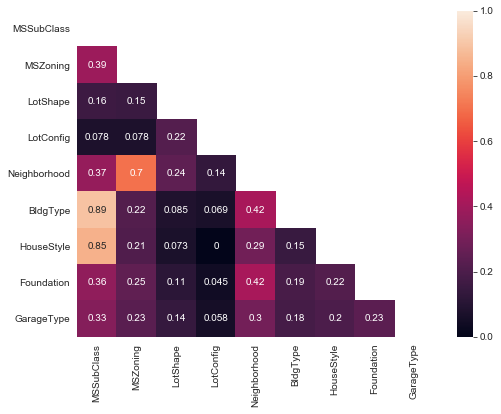

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

mask = np.zeros_like(fixed_cramers, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(fixed_cramers, mask=mask, annot=True, fmt='.2g', vmin=0, vmax=1)
plt.show()

In [33]:
# Drop columns with high correlations
housing_fixed.drop(['MSZoning', 'BldgType', 'HouseStyle'], axis=1, inplace=True)

In [34]:
housing_fixed.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig',
       'Neighborhood', 'HouseAge', 'Foundation', 'BsmtExposure', 'TotalBsmtSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'GarageType', 'GarageAge',
       'GarageCars', 'WoodDeckSF', 'PorchSF', 'YrSold'],
      dtype='object')

### Checking for distribution normality of the data

Let us check if the data is normally distributed, which is a pre-requisite for building a Linear Regression model.

In [35]:
# Separate numerical features
housing_fixed_num = housing_fixed.select_dtypes(include='number')

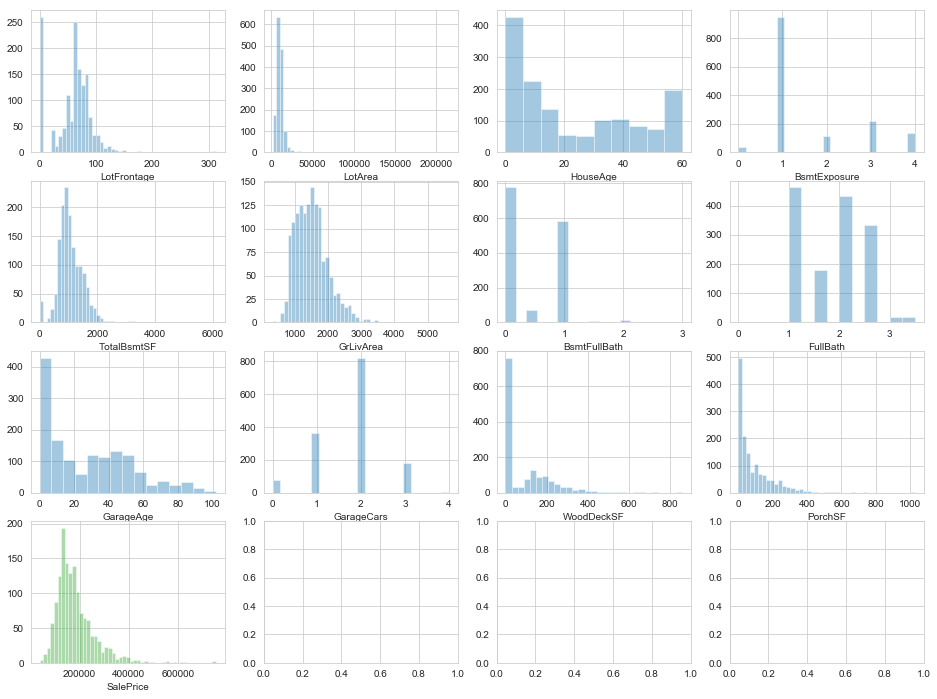

In [36]:
fig, ax = plt.subplots(4,4, figsize=(16, 12))

cols = housing_fixed_num.columns
col_count = 0

for i in range(4):
    for j in range(4):
        if col_count <=11:
            sns.distplot(housing_fixed_num[cols[col_count]], kde=False, ax=ax[i][j])
        col_count += 1

sns.distplot(housing['SalePrice'], kde=False, ax=ax[3][0], color='C2')
plt.show()

A few of the variables (as well as the target) are showing significant skew. We will log tranform these columns to make them relatively more normally distributed.

In [37]:
# Log tranform to handle skewness
housing_fixed_num = np.log(housing_fixed_num.copy() + 1)
log_sales = np.log(housing['SalePrice']+1)

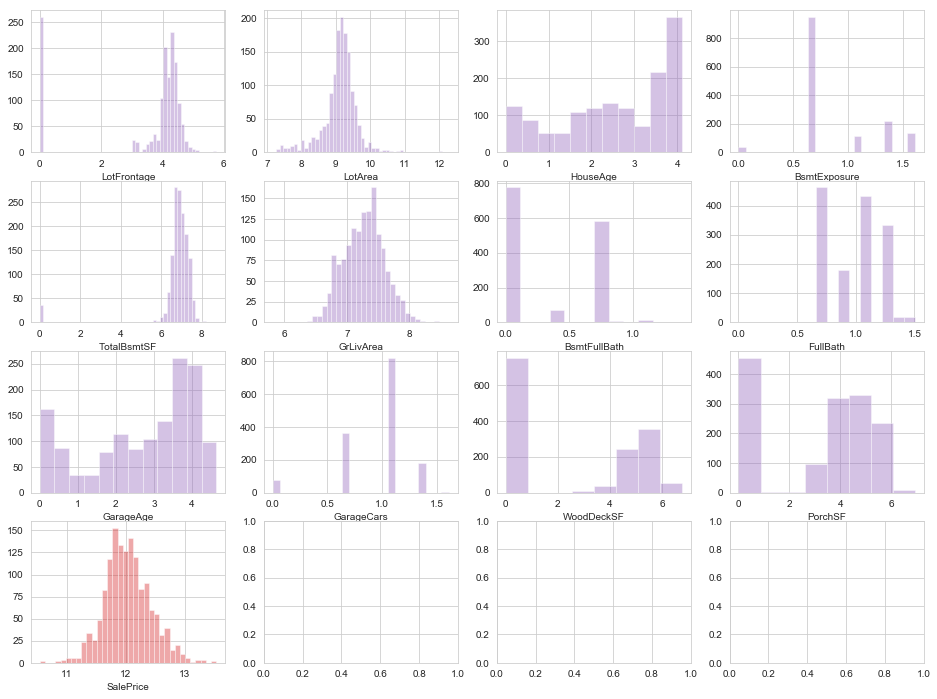

In [38]:
fig, ax = plt.subplots(4,4, figsize=(16, 12))

cols = housing_fixed_num.columns
col_count = 0

for i in range(4):
    for j in range(4):
        if col_count <=11:
            sns.distplot(housing_fixed_num[cols[col_count]], kde=False, ax=ax[i][j], color='C4')
        col_count += 1

sns.distplot(log_sales, kde=False, ax=ax[3][0], color='C3')
plt.show()

#### >>> Combining numerical Dataframe with categorical dummies:

In [39]:
for col in housing_fixed.select_dtypes(include='object').columns:
    dummy = pd.get_dummies(housing_fixed[col], prefix=col, drop_first=True)
    housing_fixed_num = pd.concat([housing_fixed_num, dummy], axis=1)

In [40]:
# Create standardized training and training splits
X_train = housing_fixed_num[housing_fixed['YrSold'] < '2010-01-01']
y_train = log_sales[X_train.index]

X_test = housing_fixed_num[housing_fixed['YrSold'] >= '2010-01-01']
y_test = log_sales[X_test.index]

ss_fixed = StandardScaler().fit(X_train)
X_train = ss_fixed.transform(X_train)
X_test = ss_fixed.transform(X_test)

In [41]:
# Test models on different Alpha Ridge values
alphas = list(range(1,35))

cross_val_scores_train = []
r2_scores_train = []
cross_val_scores_test = []
r2_scores_test = []

for al in alphas:
    lr_fixed = Ridge(alpha=al, random_state=45).fit(X_train, y_train)
    pred_fixed_train = lr_fixed.predict(X_train)
    cross_val_scores_train.append(np.mean(cross_val_score(lr_fixed, X_train, y=y_train, cv=5)))
    r2_scores_train.append(r2_score(y_train, pred_fixed_train))
    
    pred_fixed_test = lr_fixed.predict(X_test)
    cross_val_scores_test.append(np.mean(cross_val_score(lr_fixed, X_test, y=y_test, cv=5)))
    r2_scores_test.append(r2_score(y_test, pred_fixed_test))

Training R_Sq: 87.2%, Cross_Val: 84.8%
Testing R_Sq:  87.6%, Cross_Val: 83.7%


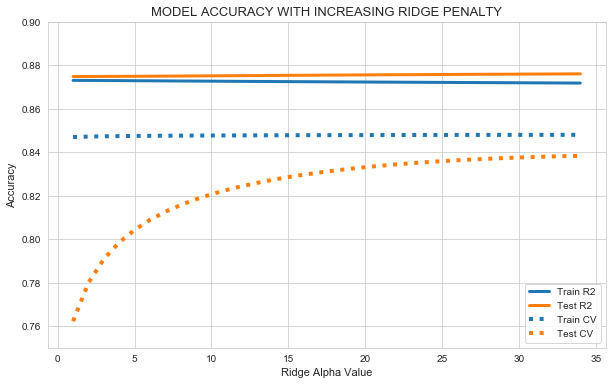

In [42]:
print('Training R_Sq: {:.1f}%, Cross_Val: {:.1f}%'.format(r2_scores_train[26]*100, cross_val_scores_train[26]*100))
print('Testing R_Sq:  {:.1f}%, Cross_Val: {:.1f}%'.format(r2_scores_test[26]*100, cross_val_scores_test[26]*100))

fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(alphas, r2_scores_train, linestyle='-', color='C0', label='Train R2', linewidth=3)
ax.plot(alphas, r2_scores_test, linestyle='-', color='C1', label='Test R2', linewidth=3)
ax.plot(alphas, cross_val_scores_train, linestyle=':', color='C0', label='Train CV', linewidth=4)
ax.plot(alphas, cross_val_scores_test, linestyle=':', color='C1', label='Test CV', linewidth=4)
ax.set_ylim(0.75, 0.9)
ax.set_title('MODEL ACCURACY WITH INCREASING RIDGE PENALTY', fontsize=13)
ax.set_xlabel('Ridge Alpha Value', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
plt.legend()
plt.show()

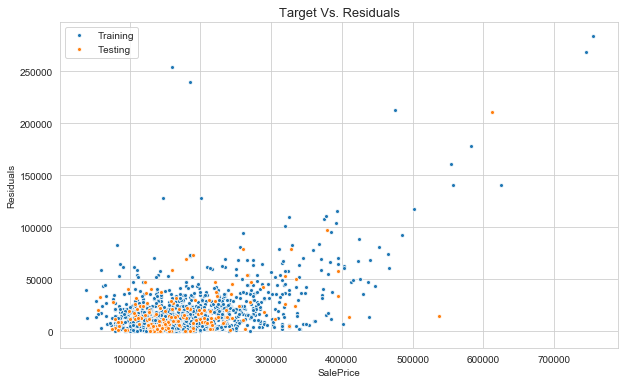

In [43]:
# Plotting residuals:
lr_fixed = Ridge(alpha=25).fit(X_train, y_train)
pred_fixed_train = lr_fixed.predict(X_train)
pred_fixed_test = lr_fixed.predict(X_test)

train_resid = abs((np.exp(y_train)-1) - (np.exp(pred_fixed_train)-1))
test_resid = abs((np.exp(y_test)-1) - (np.exp(pred_fixed_test)-1))

fig, ax = plt.subplots(1,1, figsize=(10, 6))
sns.scatterplot(x=(np.exp(y_train)-1), y=train_resid, ax=ax, label='Training', s=15)
sns.scatterplot(x=(np.exp(y_test)-1), y=test_resid, ax=ax, label='Testing', s=15)
ax.set_ylabel('Residuals')
plt.title('Target Vs. Residuals', fontsize=13)
plt.legend()
plt.show()

The above graph shows no discernable pattern, hence we can assume that there is no significant heteroscedasticity in the data used in the model.

### Conclusion:

Based on the model performance above, the best model for a Linear Regression is a Ridge with an alpha of 25.

It can be concluded that the **fixed features contribute to around 87%** of the total house price.

In the below section, I will try to identify what portion of the remaining 13% can be explained by the changeable features.


<a name="unfixed"></a>
## 4.0 Determine value of *changeable* characteristics unexplained by the *fixed* ones 
Now that I have a model that estimates the price of a house based on its static characteristics, I can move forward with part 2 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

In order to answer the above, I will use the residuals from my first model as the new target, and try to see what are the renovatable features best predicting the residuals. In a business case, it will tell me what increase in dollar value of the house (if any) the real estate agency can expect if they renovate the house.

In [44]:
# Renovatable features
change_features = ['OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                   'ExterQual', 'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 
                   'GarageFinish']

housing_changeable = housing[change_features]

In [46]:
# Converting ranked columns to numbers
dict_type1 = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
for col in ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu']:
    housing_changeable.loc[:, col] = housing_changeable[col].apply(lambda x: dict_type1[x] if x in dict_type1 else 0).copy()
    
dict_type2 = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1}
housing_changeable.loc[:, 'BsmtFinType1'] = housing_changeable['BsmtFinType1'].apply(lambda x: dict_type2[x] if x in dict_type2 else 0).copy()

dict_type3 = {'Fin': 3, 'RFn': 2, 'Unf': 1}
housing_changeable.loc[:, 'GarageFinish'] = housing_changeable['GarageFinish'].apply(lambda x: dict_type3[x] if x in dict_type3 else 0).copy()

In [47]:
# Fill Null values
housing_changeable.loc[housing_changeable['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

### Correlation

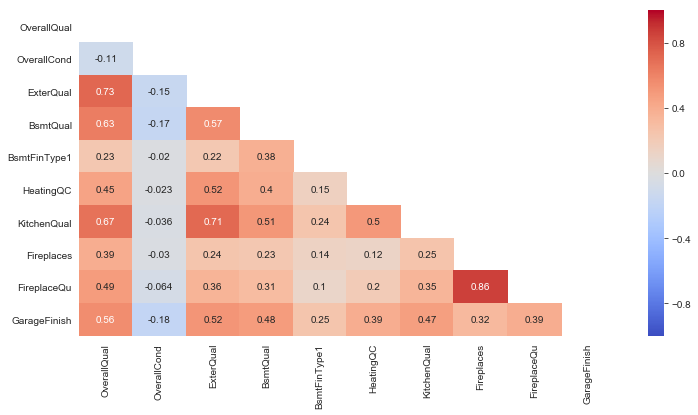

In [48]:
# Checking correlation for numerical columns
fig, ax = plt.subplots(1,1, figsize=(12,6))

corr = housing_changeable.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, fmt='.2g', vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

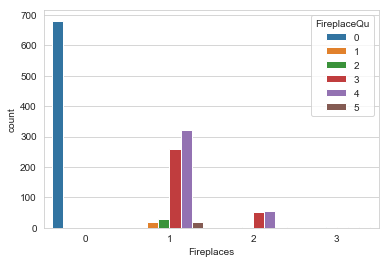

In [49]:
# Plot of fireplace and quality counts
sns.countplot(x='Fireplaces', data=housing_changeable, hue='FireplaceQu')
plt.show()

In [50]:
change_cramers = cramers_v_cross(housing_changeable.select_dtypes(include='object'))

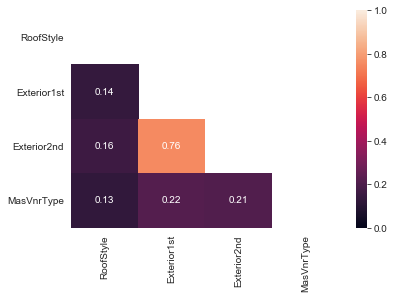

In [51]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

mask = np.zeros_like(change_cramers, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(change_cramers, mask=mask, annot=True, fmt='.2g', vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

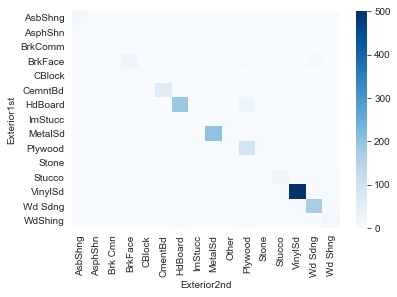

In [52]:
exter_cross = pd.crosstab(housing_changeable['Exterior1st'], housing_changeable['Exterior2nd'])

mask = np.zeros_like(exter_cross, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(exter_cross, cmap='Blues')
plt.show()

In [53]:
# Percentage of houses having a different Exterior Material
housing_changeable.loc[housing_changeable['Exterior1st']!=
                       housing_changeable['Exterior2nd']]['Exterior1st'].count() / housing_changeable.shape[0]*100

14.827586206896552

1. **Fireplaces** & **FireplaceQu** seem to be highly correlated, however that may be due to many houses houses having no fireplaces. I will drop **FireplaceQu**.
2. **ExterQual**, **BsmtQual**, **KitchenQual** and **OverallQual** have a high correlation. I will drop **OverallQual** as I have all other factors for the model to train on.
3. **Exterior1st** and **Exterior2nd** have 86% common values, so there is no point keeping both. I will only keep **Exterior1st** for my prediction.

In [54]:
housing_changeable = housing_changeable.drop(['OverallQual', 'Exterior2nd', 'FireplaceQu'], axis=1).copy()

### Checking for distribution normality of the data

Let us check if the data is normally distributed, which is a pre-requisite for building a Linear Regression model.

In [55]:
housing_changeable_num = housing_changeable.select_dtypes(include='number').copy()

In [56]:
housing_changeable_num.shape

(1450, 8)

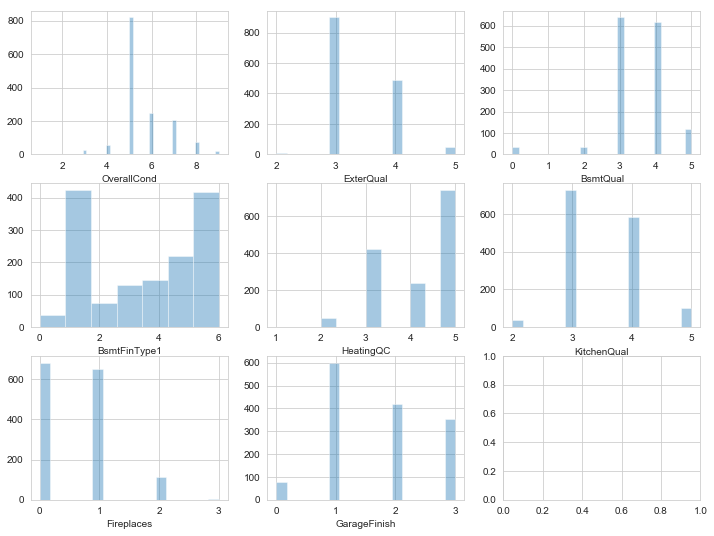

In [57]:
fig, ax = plt.subplots(3,3, figsize=(12, 9))

cols = housing_changeable_num.columns
col_count = 0

for i in range(3):
    for j in range(3):
        if col_count <= 7:
            sns.distplot(housing_changeable_num[cols[col_count]], kde=False, ax=ax[i][j])
        col_count += 1
        
plt.show()

There is no significant skew for these distributions, so I will not transform them.

In [58]:
# Creating Dataframe using dummies
roof_dummy = pd.get_dummies(housing_changeable['RoofStyle'], prefix='RoofStyle', drop_first=True)
exter_dummy = pd.get_dummies(housing_changeable['Exterior1st'], prefix='Exterior1st', drop_first=True)
masvnr_dummy = pd.get_dummies(housing_changeable['MasVnrType'], prefix='MasVnrType').drop('MasVnrType_None', axis=1)

housing_changeable_num = pd.concat([housing_changeable_num.copy(), roof_dummy, exter_dummy, masvnr_dummy], axis=1)

In [59]:
# Creating train and test data
X_train_c = housing_changeable_num.loc[housing['YrSold']!=2010, :]
y_train_c = np.log(train_resid+1)

X_test_c = housing_changeable_num.loc[housing['YrSold']==2010, :]
y_test_c = np.log(test_resid+1)

ss_change = StandardScaler()
ss_change.fit(X_train_c)
X_train_c = ss_change.transform(X_train_c)
X_test_c = ss_change.transform(X_test_c)

In [60]:
# Test models on different Alpha Ridge values
alphas = list(np.arange(35, 85, 1))

cross_val_scores_train_c = []
r2_scores_train_c = []
cross_val_scores_test_c = []
r2_scores_test_c = []

for al in alphas:
    lr_change = Ridge(alpha=al).fit(X_train_c, y_train_c)
    pred_change_train = lr_change.predict(X_train_c)
    cross_val_scores_train_c.append(np.mean(cross_val_score(lr_change, X_train_c, y=y_train_c, cv=5)))
    r2_scores_train_c.append(r2_score(y_train_c, pred_change_train))
    
    pred_change_test = lr_change.predict(X_test_c)
    cross_val_scores_test_c.append(np.mean(cross_val_score(lr_change, X_test_c, y=y_test_c, cv=5)))
    r2_scores_test_c.append(r2_score(y_test_c, pred_change_test))

Training R_Sq: 13.2%, Cross_Val: 7.4%
Testing R_Sq:  8.4%, Cross_Val: -10.5%


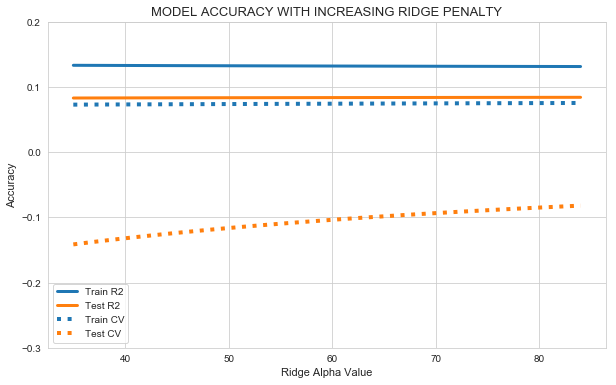

In [61]:
print('Training R_Sq: {:.1f}%, Cross_Val: {:.1f}%'.format(r2_scores_train_c[24]*100, cross_val_scores_train_c[24]*100))
print('Testing R_Sq:  {:.1f}%, Cross_Val: {:.1f}%'.format(r2_scores_test_c[24]*100, cross_val_scores_test_c[24]*100))

fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(alphas, r2_scores_train_c, linestyle='-', color='C0', label='Train R2', linewidth=3)
ax.plot(alphas, r2_scores_test_c, linestyle='-', color='C1', label='Test R2', linewidth=3)
ax.plot(alphas, cross_val_scores_train_c, linestyle=':', color='C0', label='Train CV', linewidth=4)
ax.plot(alphas, cross_val_scores_test_c, linestyle=':', color='C1', label='Test CV', linewidth=4)
ax.set_ylim(-0.3, 0.2)
ax.set_title('MODEL ACCURACY WITH INCREASING RIDGE PENALTY', fontsize=13)
ax.set_xlabel('Ridge Alpha Value', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)

plt.legend()
plt.show()

In [62]:
# Plotting residuals using Polynomials:
def polytest(x_train, y_train, x_test, y_test, dof):
    poly = PolynomialFeatures(degree=dof).fit(x_train)
    x_train = poly.transform(x_train)
    x_test = poly.transform(x_test)
    lr = Ridge(alpha=60).fit(x_train, y_train)
    train_pred = lr.predict(x_train)
    test_pred = lr.predict(x_test)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_crossval = np.mean(cross_val_score(lr, x_train, y=y_train, cv=10))
    test_crossval = np.mean(cross_val_score(lr, x_test, y=y_test, cv=10))
    
    return(abs(train_pred - y_train), abs(test_pred - y_test), train_pred, test_pred, train_r2, test_r2, train_crossval, test_crossval)

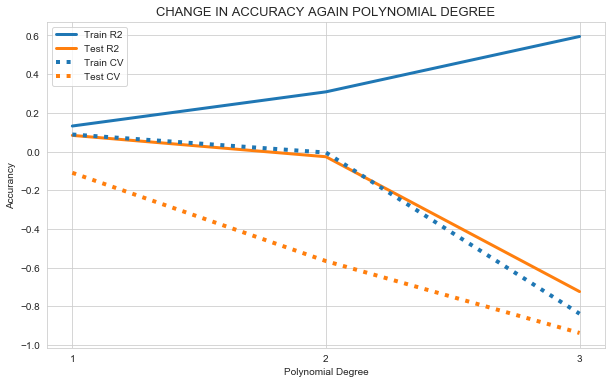

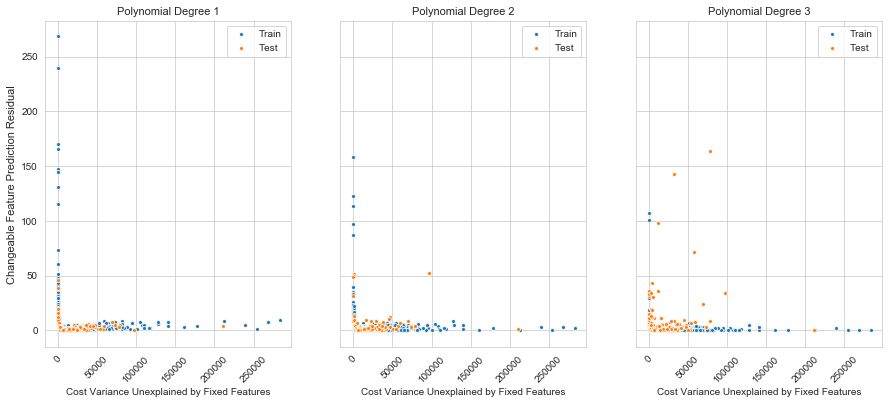

In [63]:
fig2, ax2 = plt.subplots(1,1, figsize=(10,6))
fig, ax = plt.subplots(1,3, figsize=(15,6), sharey=True)

r2_scores_train = []
r2_scores_test = []
cv_scores_train = []
cv_scores_test = []

for i in range(3):
    resid_train_c, resid_test_c, pred_train_c, pred_test_c, train_r2_c, test_r2_c, train_cv_c, test_cv_c = polytest(X_train_c, y_train_c, X_test_c, y_test_c, i+1)
    r2_scores_train.append(train_r2_c)
    r2_scores_test.append(test_r2_c)
    cv_scores_train.append(train_cv_c)
    cv_scores_test.append(test_cv_c)
    sns.scatterplot(x=(np.exp(y_train_c)-1), y=(np.exp(resid_train_c)-1), ax=ax[i], s=15, label='Train')
    sns.scatterplot(x=(np.exp(y_test_c)-1), y=(np.exp(resid_test_c)-1), ax=ax[i], s=15, label='Test')    

ax2.plot([1,2,3], r2_scores_train, label='Train R2', linestyle='-', color='C0', linewidth=3)
ax2.plot([1,2,3], r2_scores_test, label='Test R2',  linestyle='-', color='C1', linewidth=3)
ax2.plot([1,2,3], cv_scores_train, label='Train CV',  linestyle=':', color='C0', linewidth=4)
ax2.plot([1,2,3], cv_scores_test, label='Test CV',  linestyle=':', color='C1', linewidth=4)

# Chart formatting
ax2.set_title('CHANGE IN ACCURACY AGAIN POLYNOMIAL DEGREE', fontsize=13)
ax2.set_xticks([1,2,3])
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Accurancy')

ax[0].set_title('Polynomial Degree 1', fontsize=11)
ax[1].set_title('Polynomial Degree 2', fontsize=11)
ax[2].set_title('Polynomial Degree 3', fontsize=11)
ax[0].set_ylabel('Changeable Feature Prediction Residual', fontsize=11)

for i in range(3):
    plt.sca(ax[i])
    plt.xticks(rotation=45)
    plt.xlabel('Cost Variance Unexplained by Fixed Features')

ax2.legend()
plt.show()

### Conclusion:

The best model for predicting house price based on changeable features is a Ridge Regression using an alpha of 60. However this is only accounting for around **7% to 12%** of the remaining uncertainty left over from the fixed features. This is a very low figure, so we can assume at this stage that changeable features are not good predictors of the house sale price.

1. There is no significant dollar value addition to the house price using renovation in the features available in this data.
2. A model cannot be built with the renovateable features, as they are not contributing to house sale value.
3. There is less than 12% explainability in variance left over from prediction of house price based on fixed features.
4. A linear regression model cannot be used to maximum house profit using renovateable feature. It is advised to use consult a domain expert who may be able to identify some other features of the house which are renovateable and have a significant affect on house price, or can engineer the existing features to create stronger predictors for the same.

<a name="abnormal"></a>
## 5.0 Future Question: What property characteristics predict an "abnormal" sale?

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
Let's say that an executive in the real-estate company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

In future I will create a classification model to see if I can accurate predict an abnormal sale, and if yes, what factors contribute to an abnormal sale. This problem will work around target class imbalances in a classification problem.